In [123]:
import pymongo
import plotly.express as px
import pandas as pd

In [16]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["MMM_Task"]
meta_col = mydb["MMM_Task.meta"]
time_col = mydb["MMM_G26_T"]

In [ ]:
myQuery = {'timestamp': 0.40833351016044617}

In [45]:
x = time_col.find({"timestamp": {"$gt": 0}})
print(*x)

{"$$individual.id": { "$in": [ja_milch_id]}}

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [204]:
start_time = 1.5
end_time = 2
ids = ['_pI9DAGyIUGSpUuDn8rEHQ', 'DmFHsC85_km-ff0qxLoXtQ']
result = time_col.aggregate([
    {
        "$match": {"timestamp": {"$lte": end_time, "$gte": start_time}}
    },
    {
        "$project" : {
            "timestamp": 1, 
            "individuals": {
                "$filter": {
                    "input": "$individuals",
                    "as": "individual",
                    "cond": {"$in": ["$$individual.id", ids]}
                }
            }
        }
    },
    {
        "$unwind": "$individuals"
    },
    {
        "$project" : {"id": "$individuals.id", "timestamp": 1, "loc": "$individuals.loc"}
    },
    {
        "$group": 
        {
            "_id": "$id",
            "locations": {"$push": {"x": "$loc.x", "y": "$loc.y", "z": "$loc.z", "time": "$timestamp"}}
        }
    },
    {
        "$project": {"_id": 0, "id": "$_id", "timestamps": 1, "locations": 
                     {
                         "$map": {
                             "input": "$locations",
                             "as": "location",
                             "in": ["$$location.x", "$$location.y","$$location.z", "$$location.time"]
                         }
                     }
                    }
    },
    {
        "$lookup":
        {
            "from": "MMM_Task.meta",
            "let": {"id": "$id"},
            "pipeline": 
            [
                {"$unwind": "$individuals"},
                {"$project": 
                 {
                     "_id": "$individuals.id",
                     "className": "$individuals.class",
                     # "pid": "$$pid"
                 }
                },
                {"$match":{"$expr": {"$eq": ["$_id", "$$id"]}}},
            ],
            "as": "className"
        }
    },
    {
        "$project": {"id": 1, "locations": 1, "className": 
                     {
                         "$first": "$className"
                     }
                    }
    },
    {
        "$project": {"id": 1, "locations": 1, "className": "$className.className"
                    }
    }
])

for i in result:
    print(i)

{'id': 'DmFHsC85_km-ff0qxLoXtQ', 'locations': [[-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.5169340372085571], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.5726712942123413], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.6280999183654785], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.6839064359664917], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.7383676767349243], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.7909387350082397], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.8136649131774902], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.8358211517333984], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.8571341037750244], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.8790242671966553], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.902084231376648], [-38.24079132080078, 367.6930236816406, 130.5958251953125, 1.9250571727752

In [208]:
def get_trajectory(ids, start_time, end_time):
    result = time_col.aggregate([
        {
            "$match": {"timestamp": {"$lte": end_time, "$gte": start_time}}
        },
        {
            "$project" : {
                "timestamp": 1, 
                "individuals": {
                    "$filter": {
                        "input": "$individuals",
                        "as": "individual",
                        "cond": {"$in": ["$$individual.id", ids]}
                    }
                }
            }
        },
        {
            "$unwind": "$individuals"
        },
        {
            "$project" : {"id": "$individuals.id", "timestamp": 1, "loc": "$individuals.loc"}
        },
        {
            "$group": 
            {
                "_id": "$id",
                "locations": {"$push": {"x": "$loc.x", "y": "$loc.y", "z": "$loc.z", "time": "$timestamp"}}
            }
        },
            {
            "$project": {"_id": 0, "id": "$_id", "timestamps": 1, "locations": 
                         {
                             "$map": {
                                 "input": "$locations",
                                 "as": "location",
                                 "in": ["$$location.x", "$$location.y","$$location.z", "$$location.time"]
                             }
                         }
                        }
        },
        {
            "$lookup":
            {
                "from": "MMM_Task.meta",
                "let": {"id": "$id"},
                "pipeline": 
                [
                    {"$unwind": "$individuals"},
                    {"$project": 
                     {
                         "_id": "$individuals.id",
                         "className": "$individuals.class",
                     }
                    },
                    {"$match":{"$expr": {"$eq": ["$_id", "$$id"]}}},
                ],
                "as": "className"
            }
        },
        {
            "$project": {"id": 1, "locations": 1, "className": 
                         {
                             "$first": "$className"
                         }
                        }
        },
        {
            "$project": {"id": 1, "locations": 1, "className": "$className.className"
                        }
        }
    ])
    return result

In [209]:
# Works with a List of Object IDs and plots the trajectory of each object in a plot in it's own color
def plot_trajectories(object_ids):
    pf = pd.DataFrame(columns=['X', 'Y', 'Z', 'Time', 'ID'])
    
    data = list(get_trajectory(object_ids, 0, 14))
    
    for individual in data:
        individual_id = individual["id"]
        individual_class = individual["className"]
        trajectory = individual["locations"]
        df =  pd.DataFrame(trajectory, columns=['X', 'Y', 'Z', 'Time'])
        df['ID'] = f"{individual_class}: {individual_id}"
        pf = pd.concat([df, pf])
    
#     if not detect_movement(trajectory):
#         print(f"No movement for {id_to_class[object_id]}: {object_id} detected")
        
#     else:
      
    fig = px.line_3d(pf, x='X', y='Y', z='Z', color='ID', hover_name="Time", width=1000, height=600)
    # fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Time')
    fig.show()

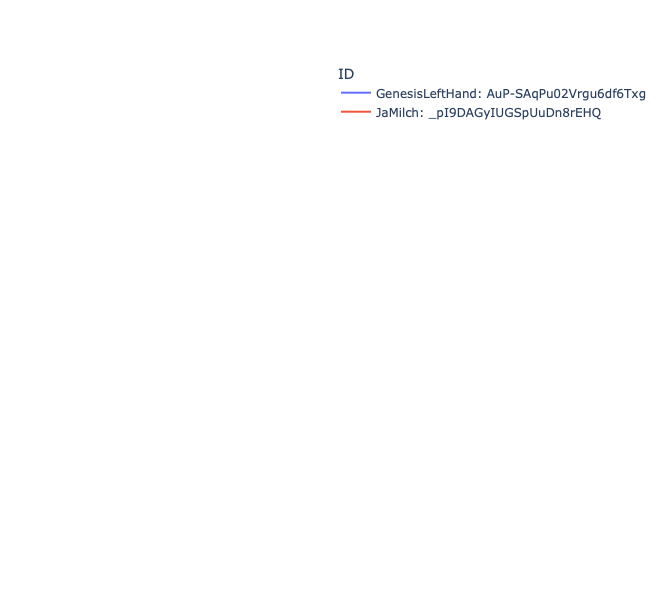

In [207]:
plot_trajectories(['AuP-SAqPu02Vrgu6df6Txg', '_pI9DAGyIUGSpUuDn8rEHQ'])